In [48]:
import findspark
findspark.init('/opt/cloudera/parcels/SPARK2/lib/spark2/')

from pyspark.sql import SparkSession



try:
    print(spark.version)
except NameError as e:
    from pyspark.sql import SparkSession
    spark = SparkSession.builder.\
        config('spark.app.name', 'academic_tree_0114').\
        config('spark.dynamicAllocation.enabled','true').\
        config('spark.dynamicAllocation.maxExecutors','50').\
        config('spark.dynamicAllocation.executorIdleTimeout','30s').\
        config('spark.driver.maxResultSize', '8g').\
        config('spark.yarn.maxAppAttempts', '20').\
        config('spark.driver.memory', '10g').\
        config('spark.executor.memory', '4g').\
        config('spark.task.maxFailures', '10').\
        config('spark.yarn.am.memory', '8g').\
        config('spark.yarn.max.executor.failures', '10').\
        config('spark.kryoserializer.buffer.max','1024m').\
        getOrCreate()
#config('spark.executor.instances', '10').\
from pyspark.ml import Pipeline
from pyspark.ml import classification
from pyspark.ml import feature
from pyspark.ml import evaluation
from pyspark.ml import tuning
from pyspark.sql import functions as fn
from pyspark.sql import Row
from pyspark.sql.functions import col, udf
from pyspark.sql.window import Window as W

sc=spark.sparkContext

2.4.0.cloudera2


In [2]:
# people = spark.read.csv('/datasets/academic_tree_20210114/people.csv', header=True)

In [3]:
# connect = spark.read.csv('/datasets/academic_tree_20210114/connect.csv', header=True)

In [4]:
# authorPub = spark.read.csv('/datasets/academic_tree_20210114/authorPub*.csv', header=True)

In [6]:
# people.write.parquet('/user/feng/academic_tree_20210114/people.parquet')

In [ ]:
# connect.write.parquet('/user/feng/academic_tree_20210114/connect.parquet')

In [ ]:
# authorPub.write.parquet('/user/feng/academic_tree_20210114/authorPub.parquet')

In [49]:
people = spark.read.parquet('/user/feng/academic_tree_20210114/people.parquet')

In [50]:
connect = spark.read.parquet('/user/feng/academic_tree_20210114/connect.parquet')

In [51]:
authorPub = spark.read.parquet('/user/feng/academic_tree_20210114/authorPub.parquet')

In [52]:
authorPub.where(fn.col('score_total') == 1).where(fn.col('doi').isNotNull()).count()

3732305

In [53]:
authorPub.where(fn.col('score_human') == 1).where(fn.col('doi').isNotNull()).count()

265348

In [54]:
authorPubFilter = authorPub.where(fn.col('score_human') == 1).where(fn.col('doi').isNotNull())

In [55]:
authorPubPid = authorPubFilter.select('pid').distinct()

In [56]:
authorPubPid.count()

15712

In [57]:
connect.printSchema()

root
 |-- cid: string (nullable = true)
 |-- pid1: string (nullable = true)
 |-- pid2: string (nullable = true)
 |-- relation: string (nullable = true)
 |-- location: string (nullable = true)
 |-- locid: string (nullable = true)
 |-- startdate: string (nullable = true)
 |-- stopdate: string (nullable = true)
 |-- addedby: string (nullable = true)
 |-- dateadded: string (nullable = true)



In [58]:
connect_left = connect.join(authorPubPid, connect.pid1 == authorPubPid.pid).select('pid1','pid2','relation','startdate','stopdate')

In [59]:
connect_left.count()

64701

In [60]:
connect_left.printSchema()

root
 |-- pid1: string (nullable = true)
 |-- pid2: string (nullable = true)
 |-- relation: string (nullable = true)
 |-- startdate: string (nullable = true)
 |-- stopdate: string (nullable = true)



In [61]:
connect_right = connect_left.join(authorPubPid, connect_left.pid2 == authorPubPid.pid).select('pid1','pid2','relation','startdate','stopdate')

In [62]:
connect_right.count()

7982

In [63]:
connect_right.printSchema()

root
 |-- pid1: string (nullable = true)
 |-- pid2: string (nullable = true)
 |-- relation: string (nullable = true)
 |-- startdate: string (nullable = true)
 |-- stopdate: string (nullable = true)



In [64]:
connect_right.groupBy('relation').count().show()

+--------+-----+
|relation|count|
+--------+-----+
|       3|  216|
|       0|  473|
|       1| 4015|
|       4|  850|
|       2| 2428|
+--------+-----+



In [17]:
# join with people to get information of name

In [65]:
people.printSchema()

root
 |-- pid: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- middlename: string (nullable = true)
 |-- lastname: string (nullable = true)
 |-- degrees: string (nullable = true)
 |-- location: string (nullable = true)
 |-- locid: string (nullable = true)
 |-- area: string (nullable = true)
 |-- majorarea: string (nullable = true)
 |-- award: string (nullable = true)
 |-- hindex: string (nullable = true)
 |-- orcid_id: string (nullable = true)
 |-- s2id: string (nullable = true)
 |-- homepage: string (nullable = true)
 |-- addedby: string (nullable = true)
 |-- dateadded: string (nullable = true)



In [66]:
peopleFilter = people.where(fn.col('lastname').isNotNull()).where(fn.col('firstname').isNotNull()).\
                        select('pid','firstname','middlename','lastname')

In [67]:
ac_tree_author_pub_name = authorPubFilter.join(peopleFilter, 'pid').distinct()

In [68]:
ac_tree_author_pub_name.count()

263723

In [69]:
ac_tree_author_pub_name.select('pid','doi','firstname','middlename','lastname').distinct().count()

261818

In [70]:
ac_tree_author_pub_name.select('pid','doi').distinct().count()

261818

In [71]:
ac_tree_author_pub_name.select('pid').distinct().count()

15538

In [24]:
ac_tree_author_pub_name.groupBy('pid','doi').count().orderBy('count', ascending = False).take(6)

[Row(pid='85538', doi='10.1111/crj.12752', count=4),
 Row(pid='76913', doi='10.1186/1471-2229-4-17', count=3),
 Row(pid='75373', doi='10.1021/jp060250n', count=3),
 Row(pid='76279', doi='10.1021/jp8057492', count=3),
 Row(pid='79467', doi='10.1021/nl2040817', count=3),
 Row(pid='75373', doi='10.1021/jp071369e', count=3)]

In [25]:
# join academic tree with MAG

In [72]:
ac_tree_author_pub_name_filter = ac_tree_author_pub_name.select('pid','doi').distinct()

In [73]:
mag_author_doi_name = spark.read.parquet('/user/feng/mentor_hub_impact/mag_author_doi_name.parquet')

In [28]:
chose_people = connect_right.select('pid1').withColumnRenamed('pid1','pid').union(connect_right.select('pid2').withColumnRenamed('pid2','pid')).distinct()

In [29]:
chose_people.count()

8767

In [30]:
ac_tree_filter_pid_doi_name = ac_tree_author_pub_name.join(chose_people, 'pid')

In [31]:
ac_tree_filter_pid_doi_name.count()

164443

In [32]:
ac_tree_filter_pid_doi_name.printSchema()

root
 |-- pid: string (nullable = true)
 |-- pubid: string (nullable = true)
 |-- score_total: string (nullable = true)
 |-- score_human: string (nullable = true)
 |-- score_coa: string (nullable = true)
 |-- pmid: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- s2id: string (nullable = true)
 |-- citations: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- middlename: string (nullable = true)
 |-- lastname: string (nullable = true)



In [33]:
ac_tree_filter_pid_doi_name.select('pid').distinct().count()

8735

In [74]:
ac_tree_author_pub_name.printSchema()

root
 |-- pid: string (nullable = true)
 |-- pubid: string (nullable = true)
 |-- score_total: string (nullable = true)
 |-- score_human: string (nullable = true)
 |-- score_coa: string (nullable = true)
 |-- pmid: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- s2id: string (nullable = true)
 |-- citations: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- middlename: string (nullable = true)
 |-- lastname: string (nullable = true)



In [75]:
ac_tree_author_pub_name.select('pid').distinct().count()

15538

In [34]:
# actually join

In [35]:
ac_tree_filter_pid_doi_name.printSchema()

root
 |-- pid: string (nullable = true)
 |-- pubid: string (nullable = true)
 |-- score_total: string (nullable = true)
 |-- score_human: string (nullable = true)
 |-- score_coa: string (nullable = true)
 |-- pmid: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- s2id: string (nullable = true)
 |-- citations: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- middlename: string (nullable = true)
 |-- lastname: string (nullable = true)



In [36]:
mag_author_doi_name.printSchema()

root
 |-- AuthorId: long (nullable = true)
 |-- Doi: string (nullable = true)
 |-- Author_NormalizedName: string (nullable = true)



In [37]:
ac_tree_filter_pid_doi_name.select('pid','doi').distinct().count()

163263

In [38]:
ac_tree_filter_pid_doi_name.where(fn.col('pid').isNull()).count()

0

In [39]:
ac_tree_filter_pid_doi_name.where(fn.col('doi').isNull()).count()

0

In [40]:
ac_tree_filter_pid_doi_name.where(fn.col('lastname').isNull()).count()

0

In [41]:
all_doi_author = ac_tree_filter_pid_doi_name.join(mag_author_doi_name, 'doi')

In [42]:
all_doi_author.count()

270910

In [43]:
all_doi_author.select('pid').distinct().count()

5606

In [76]:
all_doi_author_all_pid = ac_tree_author_pub_name.join(mag_author_doi_name, 'doi')

In [77]:
all_doi_author_all_pid.count()

460456

In [78]:
all_doi_author_all_pid.select('pid').distinct().count()

9949

In [44]:
# name matching

In [45]:
all_doi_author.printSchema()

root
 |-- doi: string (nullable = true)
 |-- pid: string (nullable = true)
 |-- pubid: string (nullable = true)
 |-- score_total: string (nullable = true)
 |-- score_human: string (nullable = true)
 |-- score_coa: string (nullable = true)
 |-- pmid: string (nullable = true)
 |-- s2id: string (nullable = true)
 |-- citations: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- middlename: string (nullable = true)
 |-- lastname: string (nullable = true)
 |-- AuthorId: long (nullable = true)
 |-- Author_NormalizedName: string (nullable = true)



In [80]:
from operator import itemgetter
from typing import Dict, List, Any, Union, Tuple
import re
from pyspark.sql.types import StringType
###################################################

# https://medium.com/@nkhaja/memoization-and-decorators-with-python-32f607439f84
# https://github.com/tkem/cachetools

from functools import wraps

def memoize(func):
    """Memoization function."""
    cache = func.cache = {}

    @wraps(func)
    def memoize_func(*args, **kwargs):
        key = str(args) + str(kwargs)
        if key not in cache:
            cache[key] = func(*args, **kwargs)
        return cache[key]

    return memoize_func

##########################################################

import sys
import unicodedata
from unidecode import unidecode

@memoize
def asciify(string):
    """Transliterate a string to ASCII."""
    string = unidecode(unicodedata.normalize("NFKD", string))
    string = string.encode("ascii", "ignore")
    string = string.decode("utf8")
    return string

###############################################################

# non (charactor, space, and comma)
RE_NORMALIZE_WHOLE_NAME = re.compile(r"[^a-zA-Z.\s]+")

# DROPPED_AFFIXES = {'i', 'ii', 'iii', 'iv', 'v', 'vi', 'jr', 'sr', 'phd', 'apr', 'rph', 'pe', 'md',
#                    'ma', 'dmd', 'cme', 'a', 'ab', 'am', 'ap', 'abu', 'al', 'auf',
#                    'aus', 'bar', 'bath', 'bat', 'ben', 'bet', 'bin', 'bint', 'd', 'da',
#                    'dall', 'dalla', 'das', 'de', 'degli', 'del', 'dell',
#                    'della', 'dem', 'den', 'der', 'di', 'do', 'dos', 'ds', 'du',
#                    'e', 'el', 'i', 'ibn', 'im', 'l', 'la', 'las', 'le', 'lo',
#                    'los', 'st.', 'st', 'te', 'ter', 'ten', 'm', 'mac', 'mc', 'mhic', 'mic', 'o',
#                    'op', 'pietro', 'und', 'v', 'van', 'vanden', 'vere', 'vom', 'von', 'zu', 'zum',
#                    'zur'}

DROPPED_AFFIXES = {'ii', 'iii', 'iv', 'vi', 'jr', 'sr', 'phd', 'apr', 'rph'}

@memoize
def normalize_name(name, drop_common_affixes=True):
    if name is None:
        return ""
    name = asciify(name).lower()
    name = RE_NORMALIZE_WHOLE_NAME.sub(" ", name)
    if drop_common_affixes:
        names = name.split(" ")
        if len(names) > 1:
            without_affixes = list(filter(lambda x: x not in DROPPED_AFFIXES, names))
            name = " ".join(without_affixes)

    name = name.strip()
    return name

normalize_name_udf = fn.udf(normalize_name, StringType())

In [81]:
from pyspark.sql.types import StringType, StructType, StructField

def concat_author_name(first_name, middle_name):
    if(first_name is None) or len(first_name) == 0:
        return normalize_name(middle_name)
    elif (middle_name is None) or len(middle_name) == 0:
        return normalize_name(first_name)
    else:
        return normalize_name(" ".join([first_name, middle_name]))
    
concat_author_name_udf = fn.udf(concat_author_name, StringType())

In [48]:
all_doi_author_actree = all_doi_author.withColumn('first_middle', concat_author_name_udf(fn.col('firstname'), fn.col('middlename')))

In [82]:
all_doi_author_all_pid_actree = all_doi_author_all_pid.withColumn('first_middle', concat_author_name_udf(fn.col('firstname'), fn.col('middlename')))

In [83]:
from pyspark.sql.types import StringType, StructType, StructField

schema = StructType([
    StructField("Author_first_name", StringType(), False),
     StructField("Author_family_name", StringType(), False),
])

def split_author_name(full_name:str):
    name_arr = full_name.split()
    if len(name_arr) == 1:
        return ("", normalize_name(full_name))
    else:
        return (normalize_name(' '.join(name_arr[:-1])), normalize_name(name_arr[-1]))
    
split_author_name_udf = fn.udf(split_author_name, schema)

In [50]:
all_doi_author_actree_MAG = all_doi_author_actree.withColumn('Author_name_arr', split_author_name_udf(fn.col('Author_NormalizedName')))

In [84]:
all_doi_author_all_pid_actree_MAG = all_doi_author_all_pid_actree.withColumn('Author_name_arr', split_author_name_udf(fn.col('Author_NormalizedName')))

In [51]:
all_doi_author_actree_MAG.printSchema()

root
 |-- doi: string (nullable = true)
 |-- pid: string (nullable = true)
 |-- pubid: string (nullable = true)
 |-- score_total: string (nullable = true)
 |-- score_human: string (nullable = true)
 |-- score_coa: string (nullable = true)
 |-- pmid: string (nullable = true)
 |-- s2id: string (nullable = true)
 |-- citations: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- middlename: string (nullable = true)
 |-- lastname: string (nullable = true)
 |-- AuthorId: long (nullable = true)
 |-- Author_NormalizedName: string (nullable = true)
 |-- first_middle: string (nullable = true)
 |-- Author_name_arr: struct (nullable = true)
 |    |-- Author_first_name: string (nullable = false)
 |    |-- Author_family_name: string (nullable = false)



In [52]:
all_doi_author_actree_MAG = all_doi_author_actree_MAG.select(
    [col for col in all_doi_author_actree_MAG.columns if col!='Author_name_arr'] + 
    [
        fn.col('Author_name_arr.Author_first_name').alias('Author_first_name'),
        fn.col('Author_name_arr.Author_family_name').alias('Author_family_name')
    ]
)

In [137]:
# all_doi_author_all_pid_actree_MAG = all_doi_author_all_pid_actree_MAG.select('doi','pid',
#                                                                               'pubid','score_total','score_human','score_coa','pmid',
#                                                                               's2id','citations','firstname','middlename','lastname',
#                                                                               'AuthorId','Author_NormalizedName','first_middle',
#                                                                               fn.col('Author_name_arr.Author_first_name').alias('Author_first_name'),
#                                                                               fn.col('Author_name_arr.Author_family_name').alias('Author_family_name')     
# )

In [86]:
all_doi_author_all_pid_actree_MAG = all_doi_author_all_pid_actree_MAG.select(
    [col for col in all_doi_author_all_pid_actree_MAG.columns if col!='Author_name_arr'] + 
    [
        fn.col('Author_name_arr.Author_first_name').alias('Author_first_name'),
        fn.col('Author_name_arr.Author_family_name').alias('Author_family_name')
    ]
)

In [88]:
all_doi_author_all_pid_actree_MAG.printSchema()

root
 |-- doi: string (nullable = true)
 |-- pid: string (nullable = true)
 |-- pubid: string (nullable = true)
 |-- score_total: string (nullable = true)
 |-- score_human: string (nullable = true)
 |-- score_coa: string (nullable = true)
 |-- pmid: string (nullable = true)
 |-- s2id: string (nullable = true)
 |-- citations: string (nullable = true)
 |-- firstname: string (nullable = true)
 |-- middlename: string (nullable = true)
 |-- lastname: string (nullable = true)
 |-- AuthorId: long (nullable = true)
 |-- Author_NormalizedName: string (nullable = true)
 |-- first_middle: string (nullable = true)
 |-- Author_first_name: string (nullable = true)
 |-- Author_family_name: string (nullable = true)



In [89]:
all_doi_author_all_pid_actree_MAG.show(5)

+--------------------+----+------+-----------+-----------+---------+-------+--------------------+---------+---------+----------+--------+----------+---------------------+------------+-----------------+------------------+
|                 doi| pid| pubid|score_total|score_human|score_coa|   pmid|                s2id|citations|firstname|middlename|lastname|  AuthorId|Author_NormalizedName|first_middle|Author_first_name|Author_family_name|
+--------------------+----+------+-----------+-----------+---------+-------+--------------------+---------+---------+----------+--------+----------+---------------------+------------+-----------------+------------------+
|10.1002/(SICI)109...|7821|789632|          1|          1|        1|9331171|df723224938b573d5...|       52|    Roger|        P.|   Croll|1971130096|        roger p croll|    roger p.|          roger p|             croll|
|10.1002/(SICI)109...|7821|789632|          1|          1|        1|9331171|df723224938b573d5...|       52|    Roger

In [90]:
from nltk.metrics.distance import edit_distance

from pyspark.sql.types import StringType, StructType, StructField, IntegerType

schema = StructType([
    StructField("matching_level", IntegerType(), False),
    StructField("matching_dist", IntegerType(), False)
])


def author_name_strict_match(pi_first_name, pi_family_name, author_first_name, author_family_name):
    pi_initial_flag = False
    author_initial_flag = False
    
    pi_full_name = pi_first_name + pi_family_name
    author_full_name = author_first_name + author_family_name
    
    if(pi_first_name is not None) and len(pi_first_name)>0:
        pi_first_name_initial = pi_first_name[0]
    else:
        pi_first_name_initial = ''
    
    if pi_first_name.find('.')!= -1 or len(pi_first_name) <=2:
        pi_initial_flag = True
    if author_first_name.find('.')!= -1 or len(author_first_name) <=2:
        author_initial_flag = True
        
    
    if(author_first_name is not None) and len(author_first_name)>0:
        author_first_name_initial = author_first_name[0]
    else:
        author_first_name_initial = ''
      
    if (pi_family_name  == author_family_name) and (pi_first_name == author_first_name):
        level = 1
        dist = 0
    elif (pi_family_name == author_family_name) and (pi_initial_flag or author_initial_flag) and (pi_first_name_initial == author_first_name_initial):
        level = 2
        dist = edit_distance(pi_first_name, author_first_name)
    elif (pi_family_name == author_family_name) and (pi_first_name_initial == author_first_name_initial):
        level = 3
        dist = edit_distance(pi_first_name, author_first_name)
    elif pi_family_name == author_family_name:
        level = 4
        dist = edit_distance(pi_first_name, author_first_name)
    elif (pi_first_name == author_first_name):
        level = 5
        dist=edit_distance(pi_family_name, author_family_name)
    elif (pi_first_name_initial == author_first_name_initial):
        level = 6
        dist = edit_distance(pi_full_name, author_full_name)
    else:
        level = 7
        dist = edit_distance(pi_full_name, author_full_name)
        
    return level, dist


def author_name_strict_match_upgraded(pi_first_name, pi_family_name, author_first_name, author_family_name):
    pi_full_name = pi_first_name + pi_family_name
    author_full_name = author_first_name + author_family_name
    if(pi_first_name is not None) and len(pi_first_name)>0:
        pi_first_name_initial = pi_first_name[0]
        pi_first_name_splited_arr = pi_first_name.split()
        pi_first_name_first_word = pi_first_name_splited_arr[0]
    else:
        pi_first_name_initial = ''
        pi_first_name_first_word = ''
        pi_first_name_splited_arr = []
    if(author_first_name is not None) and len(author_first_name)>0:
        author_first_name_initial = author_first_name[0]
        author_first_name_splited_arr = author_first_name.split()
        author_first_name_first_word = author_first_name_splited_arr[0]
    else:
        author_first_name_initial = ''
        author_first_name_first_word = ''
        author_first_name_splited_arr = []
    # R. Delhougne, K. Nestinger, Gy. Tolmár, Arthur E. Lamel, Yu. V. Kaletina, Joost P. M. van Meerwijk, Kh. M. Kholmedov
    # Daniel Acuna; DE Acuna; Daniel E. Acuna
    # With the same family name
    if (pi_family_name  == author_family_name):        
        # Fully match
        if (pi_first_name == author_first_name):
            level = 1
            dist = 0
            return level, dist
        # The same after combined
#         PI_first_name='wenchao', PI_family_name='song', Author_first_name='wen liang', Author_family_name='song'
#         PI_first_name='wenchao', PI_family_name='song', Author_first_name='wen chao', Author_family_name='song'            
#         PI_first_name='qing y', PI_family_name='zheng', Author_first_name='yiqing', Author_family_name='zheng', matching=Row(matching_level=4, matching_dist=4)
#         PI_first_name='qing y', PI_family_name='zheng', Author_first_name='qingyin', Author_family_name='zheng', matching=Row(matching_level=4, matching_dist=3)
        if ((len(pi_first_name_splited_arr)>1) and (len(author_first_name_splited_arr)==1)):
            if "".join(pi_first_name_splited_arr) == author_first_name:
                level = 1
                dist = 0
                return level, dist 
            if "".join(pi_first_name_splited_arr) in author_first_name:
                level = 2
                dist = 0
                return level, dist
        if ( ((len(pi_first_name_splited_arr)==1) and (len(author_first_name_splited_arr)>1)) ):
            if "".join(author_first_name_splited_arr) == pi_first_name:
                level = 1
                dist = 0
                return level, dist
            if "".join(author_first_name_splited_arr) in pi_first_name:
                level = 2
                dist = 0
                return level, dist
        if ((len(pi_first_name_first_word)>2) and len(author_first_name_first_word)>2) and (pi_first_name_first_word == author_first_name_first_word):
            level = 3
            dist = edit_distance(pi_first_name, author_first_name)
            return level, dist
        # If both of the first names is 3 charactors or more, check if pi_first_name and author_first_name contains each other
        if len(pi_first_name)>2 and len(author_first_name)>2:
            if (pi_first_name in author_first_name) or (author_first_name in pi_first_name):
                level = 4
                dist = edit_distance(pi_first_name, author_first_name)
                return level, dist        
            if (len(pi_first_name_first_word)>2 and (pi_first_name_first_word in author_first_name))  or (len(author_first_name_first_word)>2 and (author_first_name_first_word in pi_first_name)):
                level = 5
                dist = edit_distance(pi_first_name, author_first_name)
                return level, dist
#         PI_first_name='w timothy', PI_family_name='garvey', Author_first_name='w  john', Author_family_name='garvey'
#         PI_first_name='w timothy', PI_family_name='garvey', Author_first_name='w  timothy', Author_family_name='garvey'
#         PI_first_name='x  long', PI_family_name='zheng', Author_first_name='x  l', Author_family_name='zheng'
#         PI_first_name='x  long', PI_family_name='zheng', Author_first_name='x  w', Author_family_name='zheng'
        # if first name could divided into first name and middle name, compare the first letter of the first and middle name
        if ((len(pi_first_name_splited_arr)>1) and (len(author_first_name_splited_arr)>1)):
            if (pi_first_name_splited_arr[0][0] + pi_first_name_splited_arr[1][0]) == (author_first_name_splited_arr[0][0] + author_first_name_splited_arr[1][0]):
                level = 6
                dist = edit_distance(pi_first_name, author_first_name)
                return level, dist        
        # compare first name initial
        if len(pi_first_name)==1 or len(author_first_name) == 1:
            if (pi_first_name_initial == author_first_name_initial):
                level = 7
                dist = edit_distance(pi_first_name, author_first_name)
                return level, dist     
        # compare first name initial
        # DE acuna, Daniel Acuna
        level = 8
        dist = edit_distance(pi_first_name, author_first_name)
        return level, dist
    if (pi_first_name == author_first_name):
        level = 9
        dist=edit_distance(pi_family_name, author_family_name)
        return level, dist
    if (pi_first_name_initial == author_first_name_initial):
        level = 10
        dist = edit_distance(pi_full_name, author_full_name)
        return level, dist
    level = 11
    dist = edit_distance(pi_full_name, author_full_name)
    return level, dist


author_name_match_udf = fn.udf(author_name_match, schema)   
author_name_strict_match_udf = fn.udf(author_name_strict_match, schema)  
author_name_strict_match_upgraded_udf = fn.udf(author_name_strict_match_upgraded, schema)

In [62]:
all_doi_author_actree_MAG_strict_match = all_doi_author_actree_MAG.withColumn(
    'strong_matching', author_name_strict_match_upgraded_udf(fn.col('first_middle'),normalize_name_udf(fn.col('lastname')),fn.col('Author_first_name'),fn.col('Author_family_name'))
)

In [91]:
all_doi_author_all_pid_actree_MAG_strict_match = all_doi_author_all_pid_actree_MAG.withColumn(
    'strong_matching', author_name_strict_match_upgraded_udf(fn.col('first_middle'),normalize_name_udf(fn.col('lastname')),fn.col('Author_first_name'),fn.col('Author_family_name'))
)

In [63]:
all_doi_author_actree_MAG_strict_match.cache().count()

270910

In [64]:
all_doi_author_actree_MAG_strict_match.write.parquet('/user/feng/mentor_hub_impact/super_strong_confidence_all_doi_author_actree_MAG_human_annotate.parquet')

In [93]:
all_doi_author_all_pid_actree_MAG_strict_match.write.parquet('/user/feng/mentor_hub_impact/super_strong_confidence_all_doi_all_pid_author_actree_MAG_human_annotate.parquet', mode='overwrite')

In [ ]:
# use level 6, or level 7, please see the code

In [3]:
all_doi_author_actree_MAG_strict_match = spark.read.parquet('/user/feng/mentor_hub_impact/super_strong_confidence_all_doi_author_actree_MAG_human_annotate.parquet')

In [4]:
all_doi_author_actree_MAG_strict_match.show(10)

+--------------------+------+--------+-----------+-----------+---------+--------+--------------------+---------+---------+----------+--------+----------+---------------------+--------------+-----------------+------------------+---------------+
|                 doi|   pid|   pubid|score_total|score_human|score_coa|    pmid|                s2id|citations|firstname|middlename|lastname|  AuthorId|Author_NormalizedName|  first_middle|Author_first_name|Author_family_name|strong_matching|
+--------------------+------+--------+-----------+-----------+---------+--------+--------------------+---------+---------+----------+--------+----------+---------------------+--------------+-----------------+------------------+---------------+
|10.1002/(SICI)109...| 13451| 1191183|          1|          1|        0| 9373966|17a624905b216d4dd...|       10|     Elba|        E.| Serrano|2059441939| daniel lopezmaldo...|       elba e.|           daniel|    lopezmaldonado|       [11, 15]|
|10.1002/(SICI)109...| 1

In [5]:
from pyspark.sql.window import Window as W
pid_smallest_level_win = W.partitionBy('pid')

pid_strong_matched_paperlevellowest = all_doi_author_actree_MAG_strict_match.withColumn(
    'strong_matching_level_lowest_pid', fn.min('strong_matching.matching_level').over(pid_smallest_level_win)
)

In [6]:
pid_strong_matched_paperlevellowest.where(
    fn.col('strong_matching_level_lowest_pid') <=6
).count()

252816

In [7]:
pid_strong_matched_paperlevellowest.where(
    fn.col('strong_matching_level_lowest_pid') <=7
).count()

256513

In [8]:
pid_strong_matched_lowest = pid_strong_matched_paperlevellowest.where(
    fn.col('strong_matching.matching_level') == fn.col('strong_matching_level_lowest_pid')
).where(
    fn.col('strong_matching_level_lowest_pid') <= 6
).dropDuplicates(['AuthorId','pid'])

In [9]:
pid_strong_matched_lowest.cache().count()

6619

In [11]:
pid_strong_matched_lowest.take(5)

[Row(doi='10.1128/JVI.02672-08', pid='491037', pubid='5514950', score_total='1', score_human='1', score_coa='1', pmid='19494020', s2id='01fd6b3eced28202e2426ec7dd57cf472c0bbe5e', citations='69', firstname='Emmanuel', middlename=None, lastname='Datan', AuthorId=42226670, Author_NormalizedName='emmanuel datan', first_middle='emmanuel', Author_first_name='emmanuel', Author_family_name='datan', strong_matching=Row(matching_level=1, matching_dist=0), strong_matching_level_lowest_pid=1),
 Row(doi='10.1177/0748730416631895', pid='70097', pubid='8175938', score_total='1', score_human='1', score_coa='0.88', pmid='26955841', s2id='80b8a5a9aa6f7eed2ed1a4a938705bf6224370d0', citations='18', firstname='John', middlename='B.', lastname='Hogenesch', AuthorId=185407980, Author_NormalizedName='john b hogenesch', first_middle='john b.', Author_first_name='john b', Author_family_name='hogenesch', strong_matching=Row(matching_level=3, matching_dist=1), strong_matching_level_lowest_pid=3),
 Row(doi='10.112

In [12]:
#integrate data together

In [13]:
matching_couples = pid_strong_matched_lowest.select('pid','AuthorId')

In [14]:
matching_couples.count()

6619

In [15]:
matching_couples.distinct().count()

6619

In [116]:
# case 1: multiple pid <---> one AuthorId, delete all data

In [16]:
AuthorId_count = matching_couples.groupBy('AuthorId').count()

In [17]:
matching_couples_uniqueAuthorId = matching_couples.join(AuthorId_count.where(fn.col('count') == 1), 'AuthorId').select('pid','AuthorId')

In [18]:
matching_couples_uniqueAuthorId.count()

6601

In [20]:
# case 2: one pid <---> one AuthorId, keep all these parts of data

In [21]:
pid_count = matching_couples_uniqueAuthorId.groupBy('pid').count()

In [22]:
pid_count.orderBy('count',ascending = False).show(3)

+------+-----+
|   pid|count|
+------+-----+
| 33821|   42|
|687210|   34|
| 52007|   29|
+------+-----+
only showing top 3 rows



In [23]:
matching_couples_1vs1 = matching_couples_uniqueAuthorId.join(pid_count.where(fn.col('count') == 1), 'pid').select('pid','AuthorId')

In [24]:
matching_couples_1vs1.count()

4380

In [25]:
pid_count.where(fn.col('count') == 1).count()

4380

In [26]:
# case 3: one pid <---> multiple AuthorId, those max_score == 1, 

In [27]:
matching_couples_1vsm = matching_couples_uniqueAuthorId.join(pid_count.where(fn.col('count') > 1), 'pid').select('pid','AuthorId')

In [28]:
matching_couples_1vsm.count()

2221

In [33]:
import matplotlib

In [34]:
pid_count_1vsm = matching_couples_1vsm.groupBy('pid').count()

In [35]:
pid_to_authorId = pid_count_1vsm.select('count').toPandas()

<AxesSubplot:>

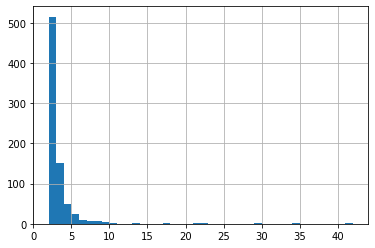

In [40]:
pid_to_authorId['count'].hist(bins=40)

In [ ]:
# all people that has a publication, without restriction of connect

In [ ]:
all_doi_author_all_pid_actree_MAG_strict_match = spark.read.parquet('/user/feng/mentor_hub_impact/super_strong_confidence_all_doi_all_pid_author_actree_MAG_human_annotate.parquet')

In [94]:
from pyspark.sql.window import Window as W
pid_smallest_level_win2 = W.partitionBy('pid')

pid_strong_matched_paperlevellowest2 = all_doi_author_all_pid_actree_MAG_strict_match.withColumn(
    'strong_matching_level_lowest_pid', fn.min('strong_matching.matching_level').over(pid_smallest_level_win2)
)

In [95]:
pid_strong_matched_paperlevellowest2.where(
    fn.col('strong_matching_level_lowest_pid') <=6
).count()

421628

In [96]:
pid_strong_matched_lowest2 = pid_strong_matched_paperlevellowest2.where(
    fn.col('strong_matching.matching_level') == fn.col('strong_matching_level_lowest_pid')
).where(
    fn.col('strong_matching_level_lowest_pid') <= 6
).dropDuplicates(['AuthorId','pid'])

In [97]:
pid_strong_matched_lowest2.cache().count()

11480

In [98]:
matching_couples2 = pid_strong_matched_lowest2.select('pid','AuthorId')

In [99]:
matching_couples2.count()

11480

In [100]:
matching_couples2.distinct().count()

11480

In [ ]:
# case 1

In [101]:
AuthorId_count2 = matching_couples2.groupBy('AuthorId').count()

In [102]:
matching_couples_uniqueAuthorId2 = matching_couples2.join(AuthorId_count2.where(fn.col('count') == 1), 'AuthorId').select('pid','AuthorId')

In [103]:
matching_couples_uniqueAuthorId2.count()

11440

In [ ]:
# case 2

In [104]:
pid_count2 = matching_couples_uniqueAuthorId2.groupBy('pid').count()

In [105]:
pid_count2.orderBy('count',ascending = False).show(3)

+------+-----+
|   pid|count|
+------+-----+
| 33821|   42|
| 51116|   38|
|156922|   35|
+------+-----+
only showing top 3 rows



In [106]:
matching_couples_1vs1_2 = matching_couples_uniqueAuthorId2.join(pid_count2.where(fn.col('count') == 1), 'pid').select('pid','AuthorId')

In [107]:
matching_couples_1vs1_2.count()

7871

In [108]:
pid_count2.where(fn.col('count') == 1).count()

7871

In [109]:
# case 3

In [110]:
matching_couples_1vsm_2 = matching_couples_uniqueAuthorId2.join(pid_count2.where(fn.col('count') > 1), 'pid').select('pid','AuthorId')

In [111]:
matching_couples_1vsm_2.count()

3569

In [115]:
7871/11480

0.6856271777003484